## Three flavours of autoencoders (AE) are implemented in this notebook.
 - Vanilla Autoencoder (vanilla-AE)
 - Convolutional Autoencoder (CNN-AE)
 - Variational Autoencoder (VAE)

Dataset used here is fashion-MNIST

[Inspired from here](https://github.com/pranay414/Fashion-MNIST-Pytorch/blob/master/fashion_mnist.ipynb) and [here](https://github.com/lharries/PyTorch-Autoencoders/blob/master/autoencoders.ipynb)

## Load libraries and setup up dataloaders

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import os

In [3]:
# get which device available and will be used for model training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
# Loading the Fashion-MNIST dataset

# # Define a transform to change the image to tensor
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, ))
                               ])

# Download and load the training data
trainset = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)
testset = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)

In [5]:
batch_size  = 128
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True)
testloader  = torch.utils.data.DataLoader(testset,  batch_size = batch_size, shuffle = True)

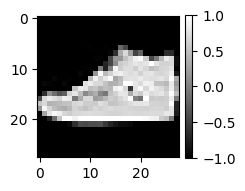

In [6]:
# Examine a sample
dataiter = iter(trainloader)
images, labels = dataiter.next()
# print(type(images))
# print(images.shape)
# print(labels.shape)
plt.figure(figsize = (2,2), dpi = 100)
plt.imshow(images[0].numpy().squeeze(), cmap = 'gray');

plt.colorbar(fraction=0.046, pad=0.04);

## Learner
We define a learner class which will take care of training, testing and visualization routines for different types of model training

In [7]:
class Learner():
  def __init__(self, train_dl, valid_dl, model, loss_func = nn.MSELoss()):
    self.train_dl, self.valid_dl = train_dl, valid_dl
    self.model        = model
    self.loss_func    = loss_func
    self.train_losses = []
    self.valid_losses = []

  # method to compute loss for each mini-batch
  def update(self,x, optm, vae):
    # forward pass of the model
    

    # compute loss
    # loss = self.loss_func(y_hat,x.squeeze())
    if vae:
      y_hat, mu, logvar = self.model(x)
      loss = self.loss_func(x, y_hat, mu, logvar)  
    else:
      y_hat = self.model(x)
      loss = self.loss_func(y_hat,x)

    
    # backward pass
    loss.backward()
    optm.step() # update parameters
    optm.zero_grad() # set parameters grads to zero
    
    return loss.item()


  # method to show visual progress after each epoch
  def show_visual_progress(self, rows, title, epoch, flatten, vae):

    image_title = f'{title}{epoch}'
    plt.title(image_title)
        
    iter(self.valid_dl)
    image_rows = []
    
    for idx, (image, label) in enumerate(self.valid_dl):
      
      #show only 5 rows of images
      if rows == idx:
          break
      
      image = image.to(device)
      if flatten:
        image = image.view(image.size(0), 28*28)

      # evaluate the images
      if vae:
        # vae model returns prediction, mu, logvar. We only need the first element from tuble, but that's not the case of other AE learner - CNN-AE, vanillaAE
        images = self.model(image)[0].detach().cpu().numpy().reshape(image.size(0),28,28)
      else:
        images = self.model(image).detach().cpu().numpy().reshape(image.size(0),28,28)


      image_idxs = [list(label.numpy()).index(x) for x in range(10)]
      combined_images = np.concatenate([images[x].reshape(28,28) for x in image_idxs],1)
      image_rows.append(combined_images)
    
    plt.imshow(np.concatenate(image_rows))
    plt.show()
    

  # method to launch training (testing) a model
  def fit(self, epochs = 1, lr = 1e-4, flatten = False, vae = False):
    opt   = torch.optim.Adam(self.model.parameters(), lr = lr) # define optimizer
    for epoch in range(epochs):
      for image, label in self.train_dl:
        image = image.to(device)
        if flatten:
          image = image.view(image.size(0), 28*28)
        self.train_losses.append(self.update(image, opt, vae=vae))
      
      for image, label in self.valid_dl:
        image = image.to(device)
        if flatten:
          image = image.view(image.size(0), 28*28)
        self.valid_losses.append(self.update(image, opt, vae= vae))
      print("Epoch number {} finished.".format(epoch))
      self.show_visual_progress(rows=5, title='AutoEncoder Learning State at Epoch: ', epoch = epoch, flatten = flatten, vae= vae)





## Vanilla Auto-Encoder

In [8]:
class AutoEncoder(nn.Module):

  def __init__(self, latent_size = 10):
    super(AutoEncoder, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(784, 512),
        nn.ReLU(),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Linear(128, latent_size)
    )

    self.decoder = nn.Sequential(
        nn.Linear(latent_size, 128),
        nn.ReLU(),
        nn.Linear(128, 512),
        nn.ReLU(),
        nn.Linear(512, 784)
    )

  def forward(self, x):
    return self.decoder(self.encoder(x))


Epoch number 0 finished.


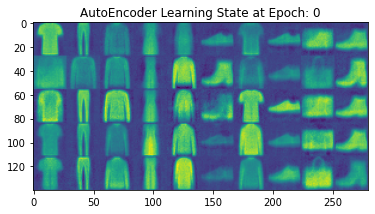

Epoch number 1 finished.


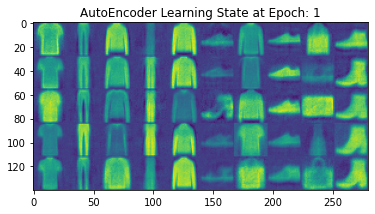

Epoch number 2 finished.


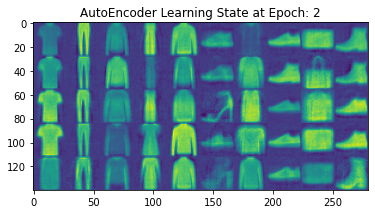

Epoch number 3 finished.


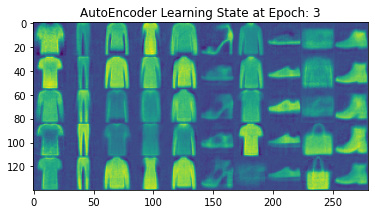

Epoch number 4 finished.


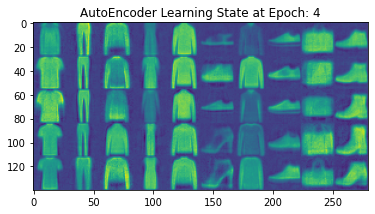

Epoch number 5 finished.


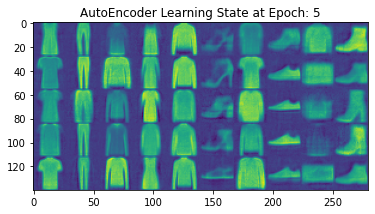

Epoch number 6 finished.


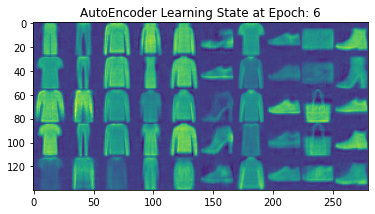

Epoch number 7 finished.


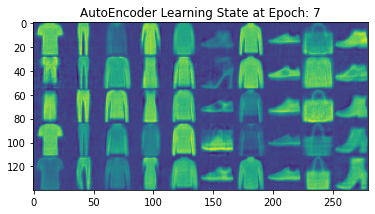

Epoch number 8 finished.


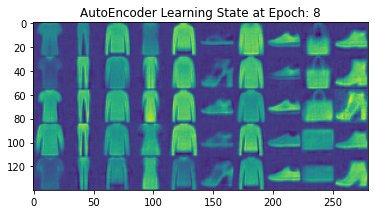

Epoch number 9 finished.


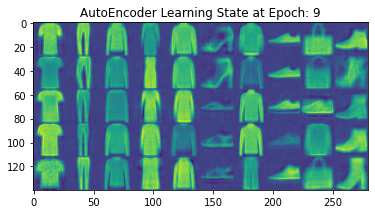

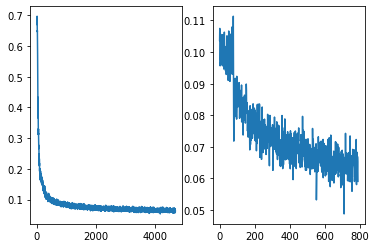

In [9]:
# start training
model = AutoEncoder().to(device)
learn = Learner(trainloader, testloader, model)
learn.fit(epochs = 10, lr = 1e-4, flatten = True)

# plot losses
plt.subplot(121)
plt.plot(learn.train_losses)
plt.subplot(122)
plt.plot(learn.valid_losses);

In [10]:
# function to get nr. of parameters in a model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Convolutional Auto-Encoder

In [11]:
class AutoEncoder_CNN(nn.Module):
  def __init__(self):

    super(AutoEncoder_CNN,self).__init__()

    #define encoder part
    self.encoder = nn.Sequential(
        nn.Conv2d(1,16, kernel_size=3, stride = 3, padding = 1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride =2),
        nn.Conv2d(16, 8, kernel_size=3, stride = 2, padding = 1),
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride = 1)
        
    )

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.ConvTranspose2d(16, 8, kernel_size=5, stride=3, padding=1),
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.ConvTranspose2d(8,1, kernel_size=2, stride = 2, padding=1),
        nn.BatchNorm2d(1),
        nn.Tanh()
    )



  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

Epoch number 0 finished.


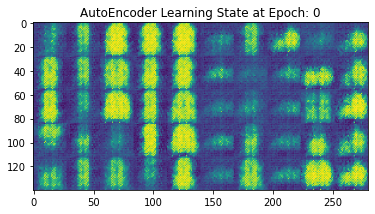

Epoch number 1 finished.


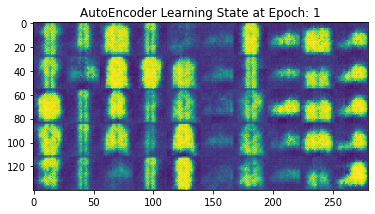

Epoch number 2 finished.


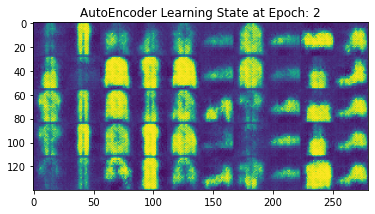

Epoch number 3 finished.


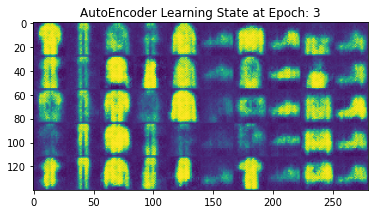

Epoch number 4 finished.


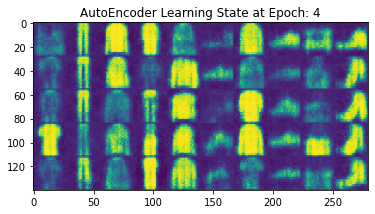

Epoch number 5 finished.


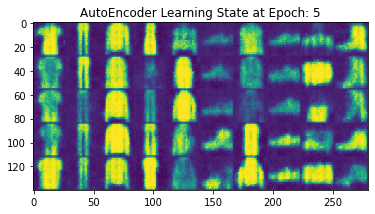

Epoch number 6 finished.


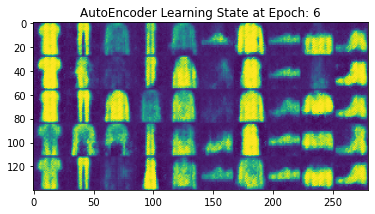

Epoch number 7 finished.


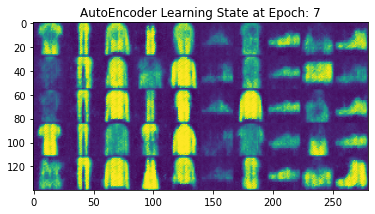

Epoch number 8 finished.


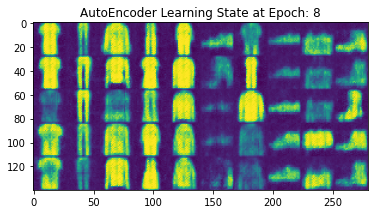

Epoch number 9 finished.


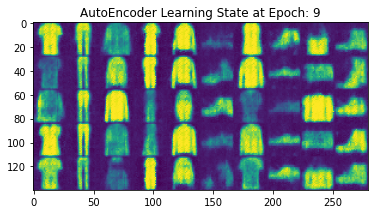

Epoch number 10 finished.


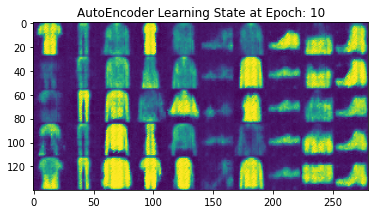

Epoch number 11 finished.


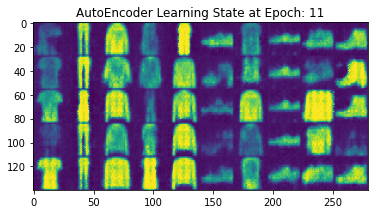

Epoch number 12 finished.


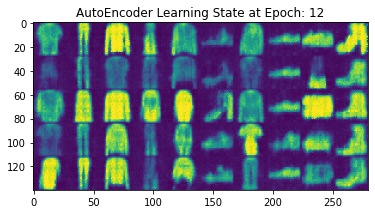

Epoch number 13 finished.


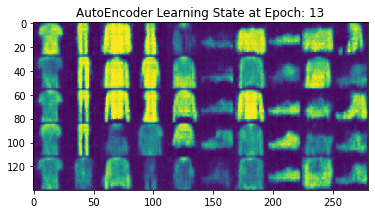

Epoch number 14 finished.


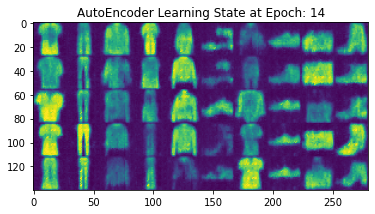

Epoch number 15 finished.


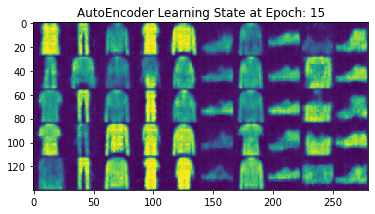

Epoch number 16 finished.


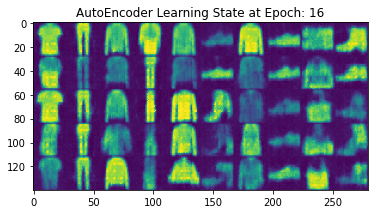

Epoch number 17 finished.


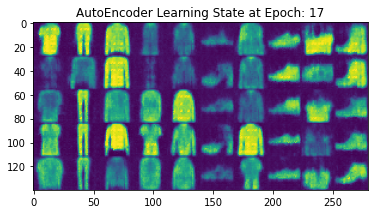

Epoch number 18 finished.


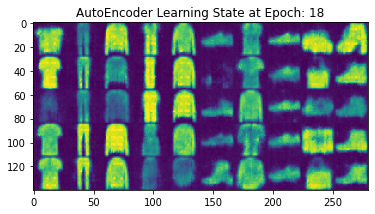

Epoch number 19 finished.


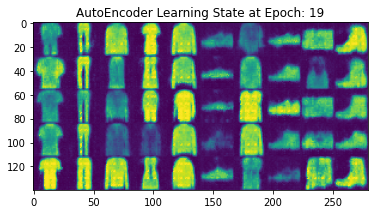

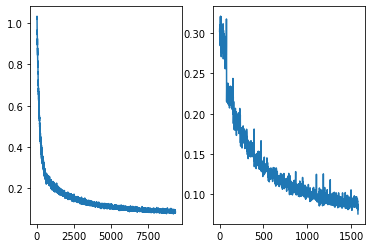

In [12]:
# train a convolutional autoencoder
model_cnn = AutoEncoder_CNN().to(device)
learn     = Learner(trainloader, testloader, model_cnn)
learn.fit(20, lr = 1e-4)

# plot losses
plt.subplot(121)
plt.plot(learn.train_losses)
plt.subplot(122)
plt.plot(learn.valid_losses);

## Variation Autoencoder
Instead of bottleneck being just the latent vector, we enforce the bottleneck to define a distribution (usually a 'normal': mean is 0, std is 1), from which decoder can sample data points

In [13]:
class VariationalAutoEncoder(nn.Module):

  def __init__(self,inp_size, hidden = 10):
    super(VariationalAutoEncoder,self).__init__()
   
    self.hidden     = hidden
    self.inp_size   = inp_size
     # encoder layers
    self.encoder = nn.Sequential(
        nn.Linear(self.inp_size, 512),
        nn.ReLU(),
        nn.Linear(512, 128)
        # nn.ReLU(),
        # nn.Linear(128, 64)

    )
    
    #latent (mean and sigma)
    self.fc_latent1 = nn.Linear(128,self.hidden)
    self.fc_latent2 = nn.Linear(128,self.hidden)

    self.relu = nn.ReLU()

    # decoder
    # self.fc3 = nn.Linear(self.hidden, 512)
    # self.fc4 = nn.Linear(512, inp_size)

    self.decoder = nn.Sequential(
        # nn.Linear(self.hidden, 64),
        # nn.ReLU(),
        nn.Linear(self.hidden,128),
        nn.ReLU(),
        nn.Linear(128, 512),
        nn.ReLU(),
        nn.Linear(512, 784)
    )


  def encoder_pass(self, x):
    x = self.relu(self.encoder(x))
    return self.fc_latent1(x), self.fc_latent2(x)

  def reparametrize(self, mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return mu + eps*std

  def decoder_pass(self, z):
    z = self.decoder(z)
    return torch.sigmoid(z)

  def forward(self, x):
    mu, logvar = self.encoder_pass(x)
    z = self.reparametrize(mu, logvar)
    x = self.decoder_pass(z)
    return x, mu, logvar


In [14]:
# need to define a special loss function for variation AE (VAE)
def vae_loss_fn(x, recon_x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD
    
loss_func = vae_loss_fn

Epoch number 0 finished.


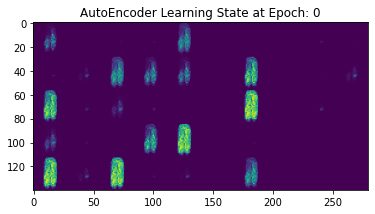

Epoch number 1 finished.


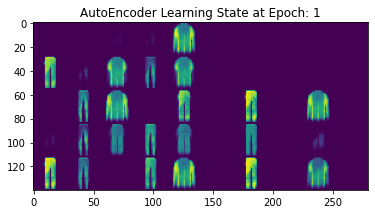

Epoch number 2 finished.


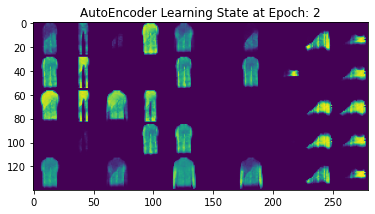

Epoch number 3 finished.


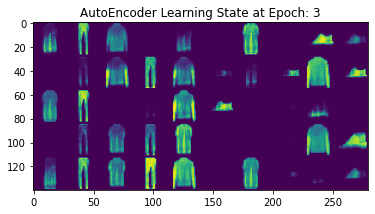

Epoch number 4 finished.


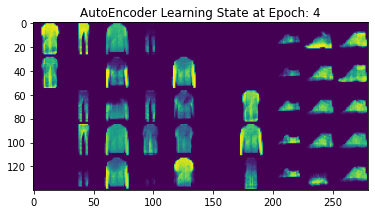

Epoch number 5 finished.


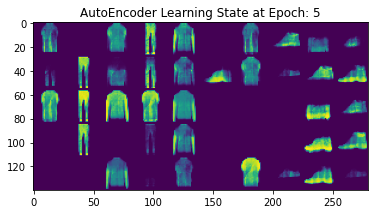

Epoch number 6 finished.


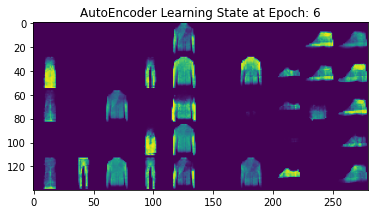

Epoch number 7 finished.


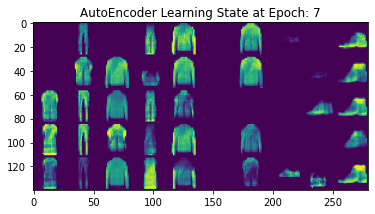

Epoch number 8 finished.


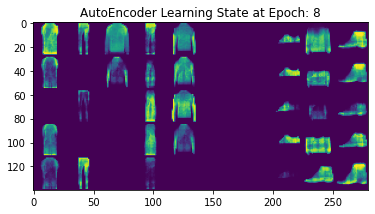

Epoch number 9 finished.


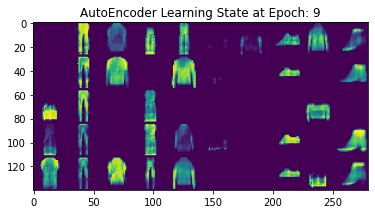

Epoch number 10 finished.


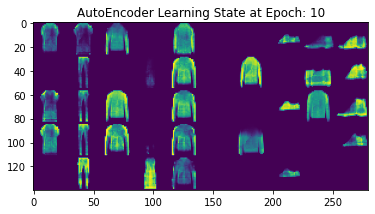

Epoch number 11 finished.


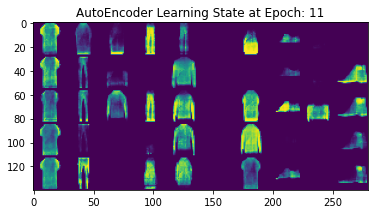

Epoch number 12 finished.


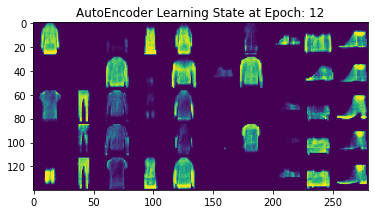

Epoch number 13 finished.


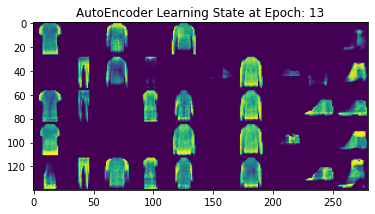

Epoch number 14 finished.


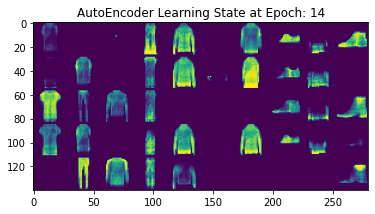

Epoch number 15 finished.


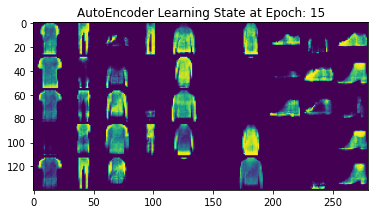

Epoch number 16 finished.


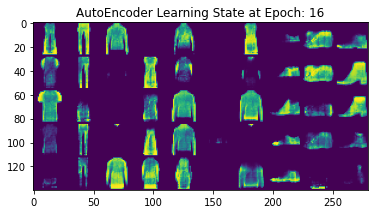

Epoch number 17 finished.


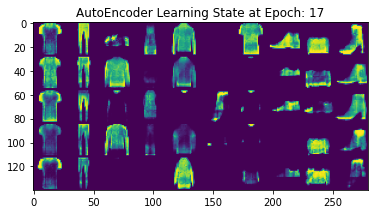

Epoch number 18 finished.


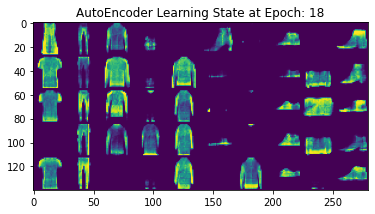

Epoch number 19 finished.


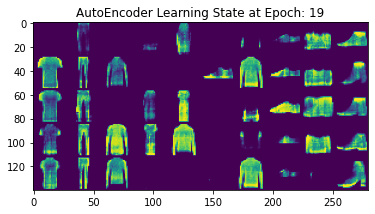

In [15]:
# start training
if 'model_vae' in locals():
  del model_vae
model_VAE = VariationalAutoEncoder(28*28, 64).to(device)
learn     = Learner(trainloader, testloader,model_VAE, loss_func=loss_func)
learn.fit(20, lr = 1e-4, flatten = True, vae = True)

It seems like VAE are a bit of overkill for the problem at hand

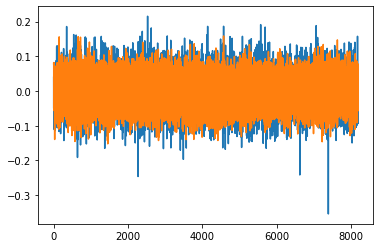

In [16]:
# plot only latent parameters mu, sigma
for name, param in model_VAE.named_parameters():
  if param.requires_grad:
    if name in ['fc_latent1.weight', 'fc_latent2.weight']:
    #  print(name, param.data.view(-1))

     plt.plot(param.data.detach().cpu().view(-1))

In [18]:
print(count_parameters(model))
print(count_parameters(model_cnn))
print(count_parameters(model_VAE))


938522
5827
960656


## More reading / project material on AutoEncoder (AE)...Note to self
- Disentangled VAE ( $\beta$-VAE )
- Denoising AE
- Autoencoders for Anamolgy detection
- Neural Inpainting (removing watermarks from images, objects, etc...)